In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from sklearn.metrics import mean_absolute_percentage_error
from pmdarima import auto_arima

In [2]:
from IPython.core.pylabtools import figsize
SIZE_X = 14
SIZE_Y = 7
figsize(SIZE_X, SIZE_Y)
sns.set_theme()

In [57]:
df = pd.read_csv('Apple_Historical_StockPrice2.csv')
df.Date = pd.to_datetime(df.Date, format='%Y/%m/%d')
df = df.set_index(['Date'])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2016-03-28 to 2021-03-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1260 non-null   float64
 1   High       1260 non-null   float64
 2   Low        1260 non-null   float64
 3   Close      1260 non-null   float64
 4   Adj Close  1260 non-null   float64
 5   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


<AxesSubplot:xlabel='Date'>

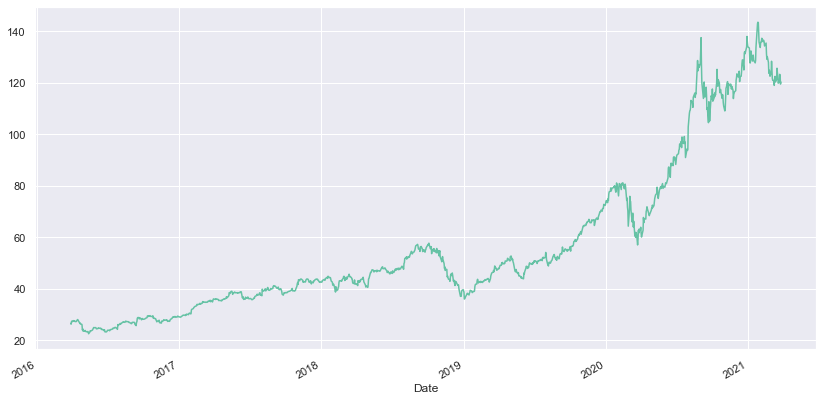

In [58]:
df.Open.plot()

<AxesSubplot:xlabel='Date'>

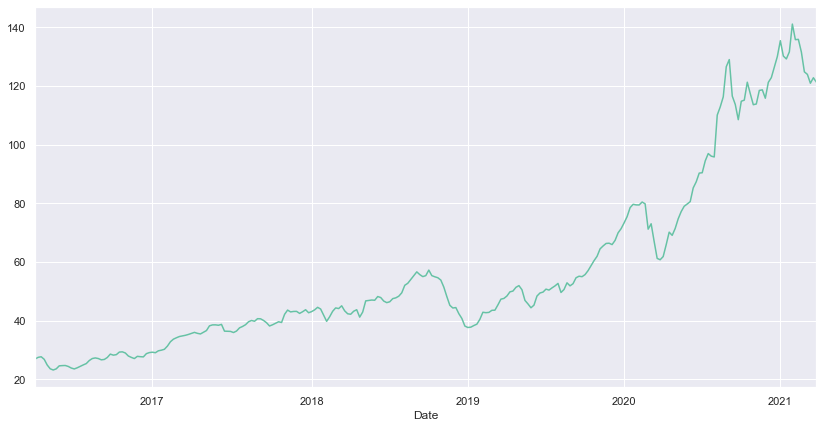

In [59]:
df = df.resample('W').mean()
df.Open.plot()

<AxesSubplot:title={'center':'Residual'}, xlabel='Date'>

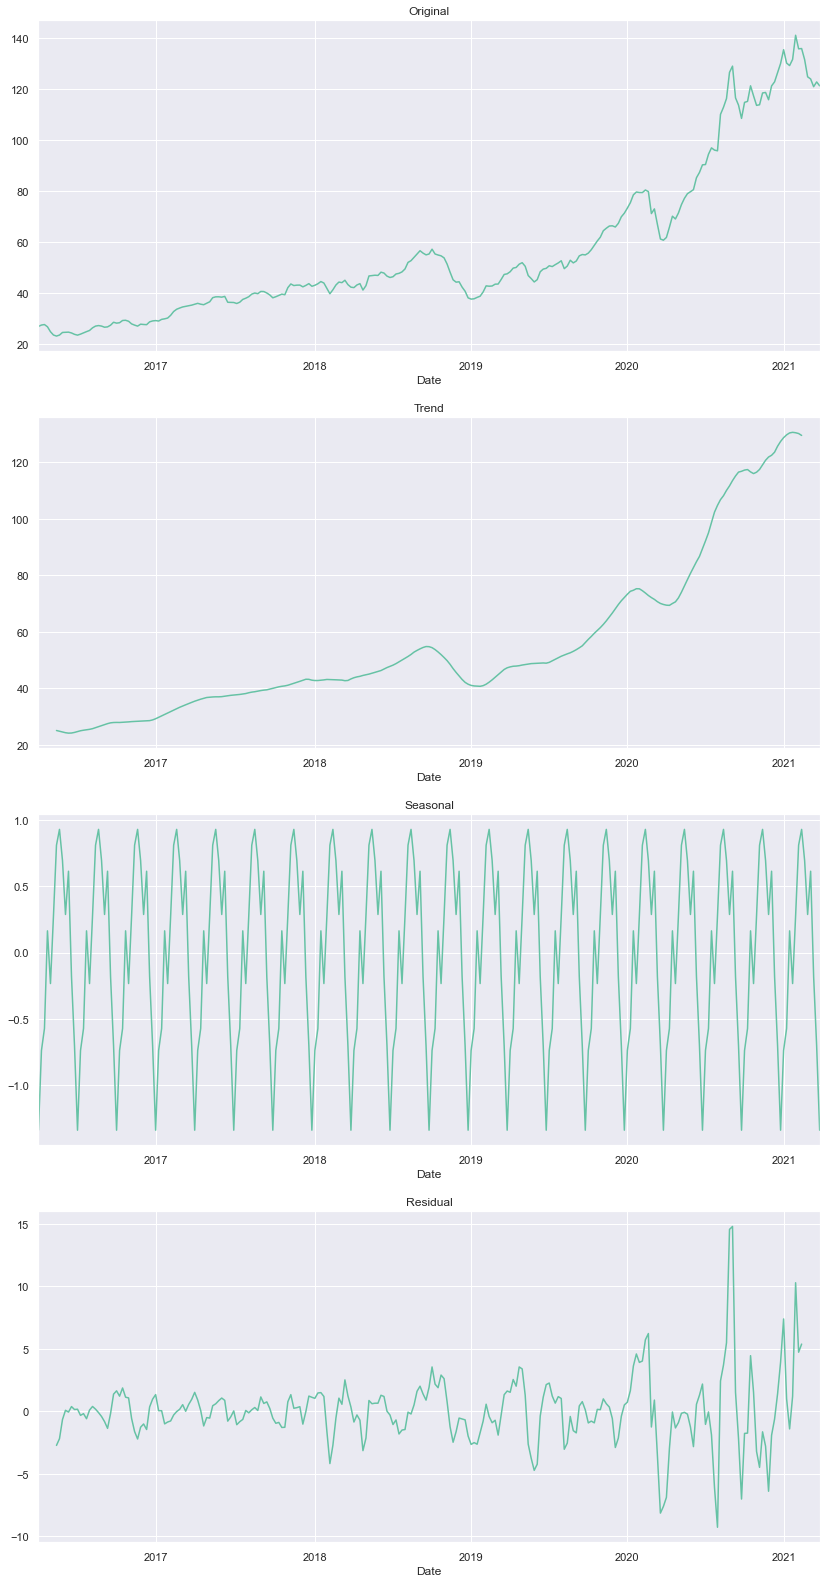

In [60]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(SIZE_X, SIZE_Y * 4))
decompose = seasonal_decompose(df.Open, period=13)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

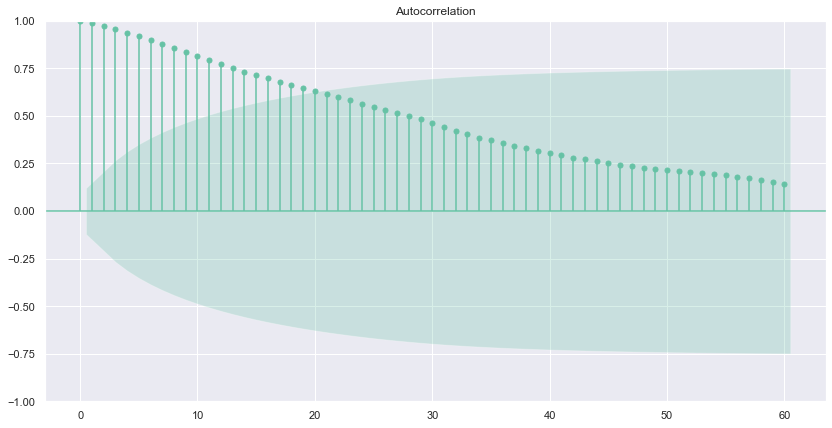

In [61]:
plot_acf(df.Open, lags=60)
plt.show()

<AxesSubplot:xlabel='Date'>

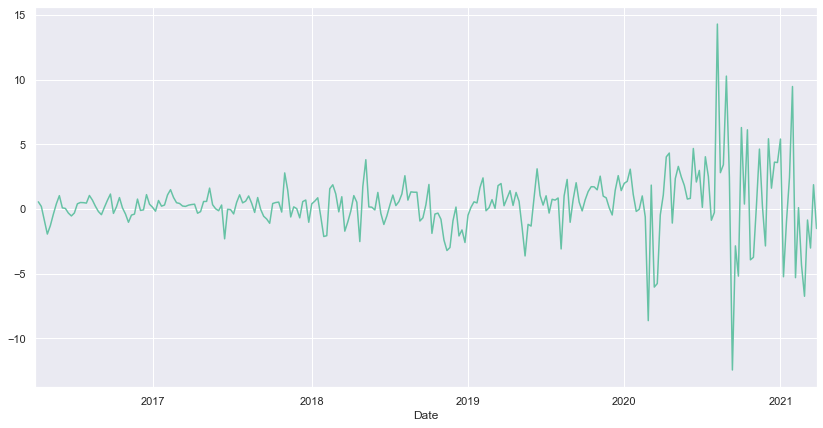

In [62]:
df['Open_diff'] = df.Open.diff()
df.Open_diff.plot()

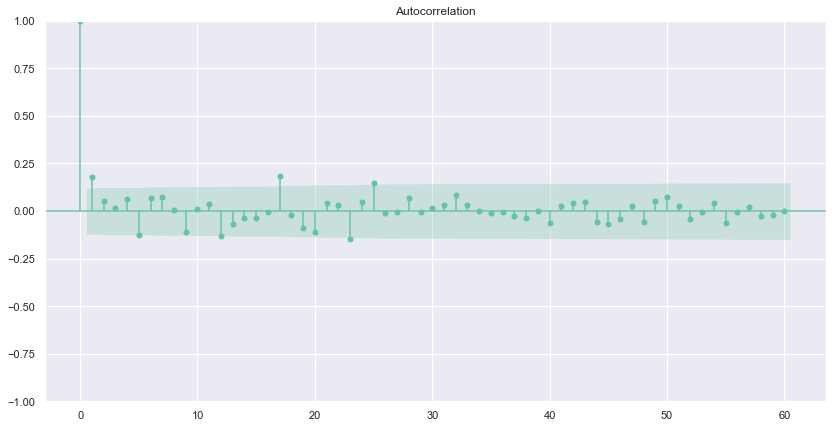

In [63]:
plot_acf(df.Open_diff[1:], lags=60)
plt.show()

<AxesSubplot:xlabel='Date'>

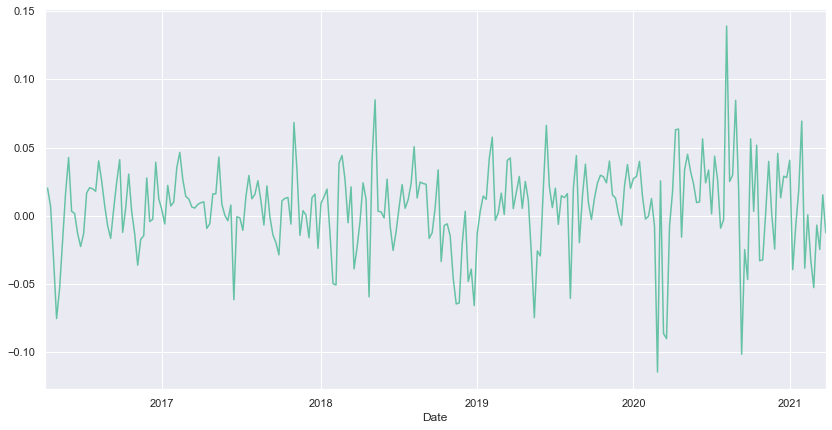

In [64]:
df['Open_log'] = np.log(df.Open)
df['Open_log_diff'] = df.Open_log.diff()
df.Open_log_diff.plot()

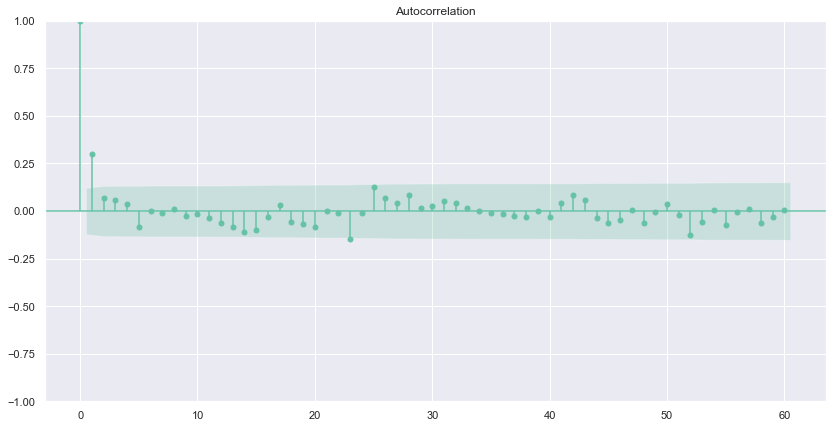

In [65]:
plot_acf(df.Open_log_diff[1:], lags=60)
plt.show()

In [12]:
p_value = adfuller(df.Open_log_diff[1:])[1]
print(
    f'Полученный уровень значимости (p-value): {p_value:.4f}, порядок {np.log10(p_value):.0f};',
    f'{p_value:.4f} < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!'
)

Полученный уровень значимости (p-value): 0.0000, порядок -21; 0.0000 < 0.05. Нулевая гипотеза отвергается в пользу альтернативной!


<AxesSubplot:xlabel='Open_log_diff', ylabel='Count'>

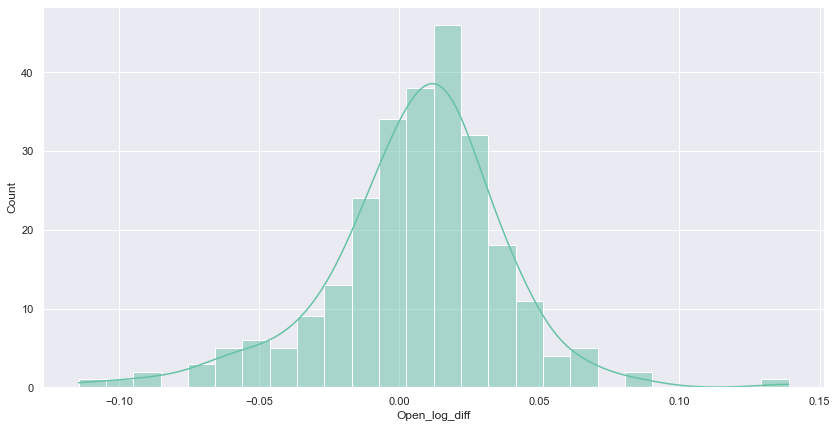

In [66]:
sns.histplot(data=df[1:], x='Open_log_diff', kde=True)

In [32]:
from itertools import product
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
ds = range(0, 3)
D = 1
qs = range(1, 3)
Qs = range(1, 3)
ps = range(1, 3)
Ps = range(3, 5)
params = product(ps, ds, qs, Ps, Qs)
results = []
best_aic = float("inf")

for (p, d, q, P, Q) in tqdm(list(params)):
    model = sm.SARIMAX(df.Open_log.head(int(len(df) * 0.8)),
                       order=(p, d, q),
                       seasonal_order=(P, D, Q, 13)).fit(disp=-1)
    if model.aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = (p, q, d, P, Q)
    results.append([(p, q, d, P, Q), model.aic])

100%|██████████| 48/48 [13:26<00:00, 16.80s/it]


In [26]:
# best_model = auto_arima(df.Open_log.head(int(len(df) * 0.8)),
#                             start_p=1, start_q=1,
#                             max_p=3, max_q=3, m=13,
#                             start_P=0, seasonal=True,
#                             d=1, D=1, trace=True,
#                             error_action='ignore',  # don't want to know if an order does not work
#                             suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[13]             : AIC=inf, Time=4.16 sec
 ARIMA(0,1,0)(0,1,0)[13]             : AIC=-682.003, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[13]             : AIC=-772.321, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[13]             : AIC=inf, Time=1.20 sec
 ARIMA(1,1,0)(0,1,0)[13]             : AIC=-718.333, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[13]             : AIC=-787.332, Time=1.70 sec
 ARIMA(1,1,0)(2,1,1)[13]             : AIC=inf, Time=3.94 sec
 ARIMA(1,1,0)(1,1,1)[13]             : AIC=inf, Time=1.64 sec
 ARIMA(0,1,0)(2,1,0)[13]             : AIC=-760.226, Time=0.71 sec
 ARIMA(2,1,0)(2,1,0)[13]             : AIC=-785.856, Time=1.87 sec
 ARIMA(1,1,1)(2,1,0)[13]             : AIC=-786.385, Time=1.95 sec
 ARIMA(0,1,1)(2,1,0)[13]             : AIC=-787.814, Time=1.13 sec
 ARIMA(0,1,1)(1,1,0)[13]             : AIC=-772.860, Time=0.47 sec
 ARIMA(0,1,1)(2,1,1)[13]             : AIC=-803.416, Time=2.68 sec
 ARIMA(0,1,1)(1,1,1)[13]             : 

In [33]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True).head()

,parameters,aic
10,"(1, 1, 1, 4, 1)",-813.264983
11,"(1, 1, 1, 4, 2)",-811.640479
7,"(1, 2, 0, 4, 2)",-811.513928
15,"(1, 2, 1, 4, 2)",-810.742495
35,"(2, 1, 1, 4, 2)",-810.581837


In [34]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           Open_log   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(4, 1, 1, 13)   Log Likelihood                 414.632
Date:                            Wed, 24 Nov 2021   AIC                           -813.265
Time:                                    18:15:04   BIC                           -787.122
Sample:                                04-03-2016   HQIC                          -802.679
                                     - 03-22-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1208      0.179     -0.675      0.500      -0.472       0.230
ma.L1          0.4916      0.158      3.104      0.002       0.181       0.802
ar.S.L13      -0.3652      0.150     -2.442      0.015      -0.658      -0.072
ar.S.L26      -0.2045      0.147     -1.393      0.163      -0.492       0.083
ar.S.L39      -0.2361      0.103     -2.284      0.022      -0.439      -0.034
ar.S.L52      -0.3596      0.091     -3.970      0.000      -0.537      -0.182
ma.S.L13      -0.6145      0.167     -3.673      0.000      -0.942      -0.287
sigma2         0.0007   5.74e-05     12.458      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                67.01
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
df['Model'] = np.exp(best_model.predict(start=int(len(df) * 0.8)-1, end = len(df)))

<AxesSubplot:xlabel='Date'>

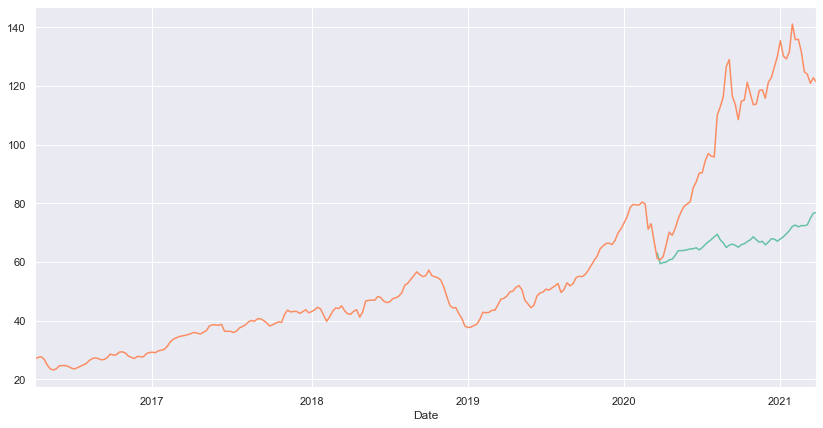

In [70]:
df.Model.plot()
df.Open.plot()
# np.exp(best_model.fittedvalues).plot()

In [74]:
mean_absolute_percentage_error(df.Open[int(len(df) * 0.8):],
                               df.Model[int(len(df) * 0.8):])

0.34976893402093884